In [ ]:
!pip install --upgrade transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, get_linear_schedule_with_warmup
from datasets import load_dataset, Dataset
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import torch, numpy as np, pandas as pd, pickle, os

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_and_prepare(max_length=256):
    ds = load_dataset('ag_news')
    tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    tokenizer.model_max_length = max_length
    def tokenize_batch(batch):
        return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=max_length)
    data = ds.map(tokenize_batch, batched=True)
    data = data.rename_column('label', 'labels')
    data.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
    return data, tokenizer

In [ ]:
def assemble_model():
    base = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=4)
    targets = [f"roberta.encoder.layer.{i}.attention.self.{mod}" for i in range(8, 12) for mod in ('query', 'value')]
    cfg = LoraConfig(task_type=TaskType.SEQ_CLS, bias='none', target_modules=targets, r=8, lora_alpha=32, lora_dropout=0.05)
    model = get_peft_model(base, cfg).to(device)
    return model

In [ ]:

def configure_training(model, dataset_splits, epochs=5, train_bs=16, eval_bs=64):
    total_steps = (len(dataset_splits['train']) // train_bs) * epochs
    warmup_steps = int(0.1 * total_steps)
    lr_groups = []
    for idx, layer in enumerate(model.roberta.encoder.layer):
        lr = 1e-5 if idx < 4 else 3e-4 if idx < 8 else 5e-4
        lr_groups.append({'params': layer.parameters(), 'lr': lr})
    lr_groups.append({'params': model.classifier.parameters(), 'lr': 1e-3})
    args = TrainingArguments(
        output_dir='./results/layerwise_experiments', num_train_epochs=epochs,
        per_device_train_batch_size=train_bs, per_device_eval_batch_size=eval_bs,
        gradient_accumulation_steps=1, eval_strategy='epoch', save_strategy='epoch',
        load_best_model_at_end=True, metric_for_best_model='accuracy', greater_is_better=True,
        save_total_limit=2, logging_strategy='steps', logging_steps=500,
        logging_dir='./logs', report_to='none', fp16=True, max_grad_norm=1.0
    )
    return lr_groups, args, warmup_steps, total_steps

In [ ]:
data_splits, tok = load_and_prepare()
clf = assemble_model()
optim_groups, train_args, warm_steps, all_steps = configure_training(clf, data_splits)

def eval_fn(preds):
    return {'accuracy': accuracy_score(preds.label_ids, np.argmax(preds.predictions, axis=-1))}

for opt_name, OptClass in {'RMSprop': torch.optim.RMSprop}.items():
    optimizer = OptClass(optim_groups, weight_decay=0.01)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warm_steps, num_training_steps=all_steps)
    trainer = Trainer(
        model=clf, args=train_args,
        train_dataset=data_splits['train'], eval_dataset=data_splits['test'],
        tokenizer=tok, compute_metrics=eval_fn,
        optimizers=(optimizer, scheduler)
    )
    trainer.train()
    trainer.save_model(f"./results/layerwise_experiments/{opt_name}")
    print(trainer.evaluate())

def create_submission():
    with open('/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl', 'rb') as f:
        raw = pickle.load(f)
    ds = Dataset.from_dict({'text': raw['text']})
    ds = ds.map(lambda b: tok(b['text'], truncation=True, padding='max_length', max_length=128), batched=True)
    ds.set_format('torch', columns=['input_ids', 'attention_mask'])
    loader = DataLoader(ds, batch_size=64)
    for name in ['RMSProp']:
        base = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=4, local_files_only=True)
        adapter = PeftModel.from_pretrained(base, f"/kaggle/working/results/layerwise_experiments/{name}", local_files_only=True).to(device)
        adapter.eval()
        preds = []
        for batch in loader:
            b = {k: v.to(device) for k, v in batch.items()}
            logits = adapter(**b).logits
            preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        df = pd.DataFrame({'ID': list(range(len(preds))), 'label': preds})
        df.to_csv(f'submission_{name}.csv', index=False)
        print(df['label'].value_counts())

create_submission()

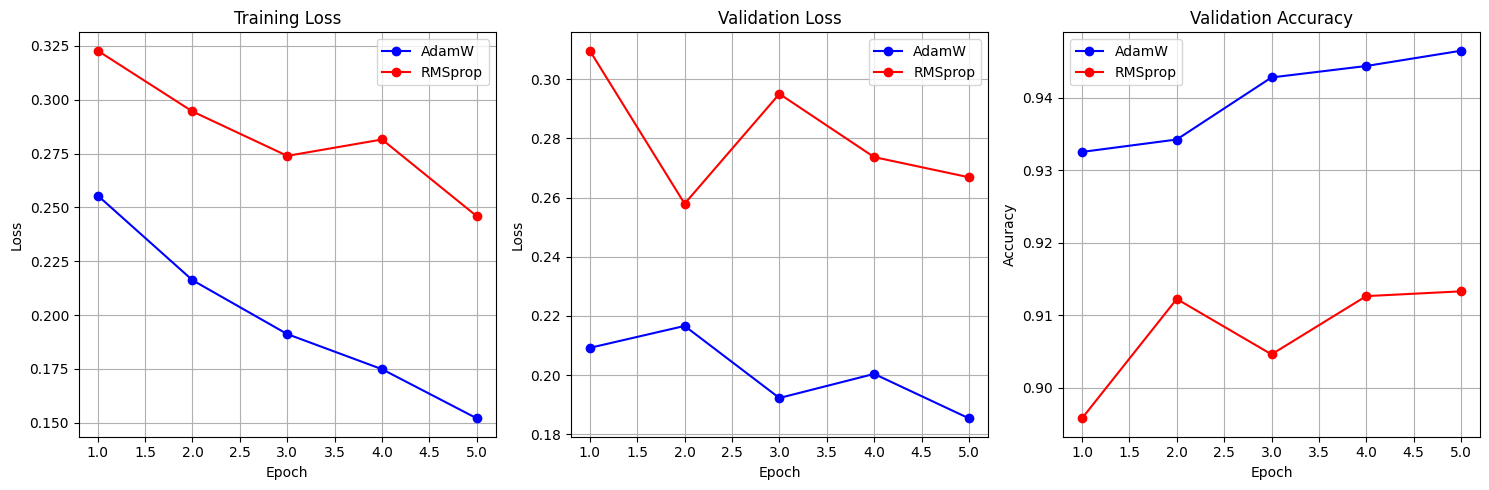

In [3]:
import matplotlib.pyplot as plt
import numpy as np

#################################
# Data graphs
#################################
# The data gathered is used to compare the optimizer AdamW and RMSprop data
# This data was taken from a Kaggle notebook and saved as an array
# This is because re-running the models will take forever, so here is the data hard-coded

# epochs
epochs = np.arange(1, 6)

# AdamW data
adamw_train_loss = [0.255500, 0.216200, 0.191200, 0.174900, 0.152100]
adamw_val_loss = [0.209213, 0.216617, 0.192260, 0.200402, 0.185381]
adamw_accuracy = [0.932500, 0.934211, 0.942763, 0.944342, 0.946447]

# RMSprop data
rmsprop_train_loss = [0.322700, 0.294500, 0.273900, 0.281500, 0.245900]
rmsprop_val_loss = [0.309663, 0.257936, 0.295074, 0.273692, 0.266886]
rmsprop_accuracy = [0.895789, 0.912237, 0.904605, 0.912632, 0.913289]

# Create figure with 3 subplots
plt.figure(figsize=(15, 5))

# plot of training loss over epochs
plt.subplot(1, 3, 1)
plt.plot(epochs, adamw_train_loss, 'b-o', label='AdamW')
plt.plot(epochs, rmsprop_train_loss, 'r-o', label='RMSprop')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# plot of validation loss over epochs
plt.subplot(1, 3, 2)
plt.plot(epochs, adamw_val_loss, 'b-o', label='AdamW')
plt.plot(epochs, rmsprop_val_loss, 'r-o', label='RMSprop')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# plot of accuracy over epochs
plt.subplot(1, 3, 3)
plt.plot(epochs, adamw_accuracy, 'b-o', label='AdamW')
plt.plot(epochs, rmsprop_accuracy, 'r-o', label='RMSprop')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()